In [1]:
import torch.nn as nn
import torch

import sys, os
import random
import numpy as np
from shutil import copy
import matplotlib.pyplot as plt
from copy import deepcopy

from omegaconf import OmegaConf
import shutil
import pickle
import random
from tqdm import tqdm

In [2]:
# run_path = '/home/harishbabu/projects/PIPNet/runs/010-CUB-27-imgnet_OOD_cnext26_img=224_nprotos=20'
# run_path = '/home/harishbabu/projects/PIPNet/runs/031-CUB-18-imgnet_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/032-CUB-18-imgnet_cnext26_img=224_nprotos=20_orth-on-rel'

# run_path = '/home/harishbabu/projects/PIPNet/runs/035-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel'

# run_path = '/home/harishbabu/projects/PIPNet/runs/043-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = "/home/harishbabu/projects/PIPNet/runs/036-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel_uniformity"
# run_path = "/home/harishbabu/projects/PIPNet/runs/041-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/042-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel"

# run_path = "/home/harishbabu/projects/PIPNet/runs/044-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20-or-4per-desc_orth-on-rel"

# run_path = "/home/harishbabu/projects/PIPNet/runs/046-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=10per-desc_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/047-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=5per-desc_tanh-desc"
# run_path = "/home/harishbabu/projects/PIPNet/runs/048-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=5per-desc_tanh-desc_unit-sphere"
# run_path = "/home/harishbabu/projects/PIPNet/runs/051-CUB-18-imgnet_cnext26_img=224_nprotos=4per-desc_tanh-desc_unit-sphere_AW=5-TW=2-UW=2-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/052-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=4per-desc_tanh-desc_unit-sphere_AW=5-TW=2-UW=2-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/055-CUB-18_cnext26_img=224_nprotos=4per-desc_unit-sphere_no-softmax_AW=3-TW=2-UW=3-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/056-CUB-18-imgnet_cnext26_img=224_nprotos=4per-desc_unit-sphere_no-softmax_AW=3-TW=2-UW=3-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/057-CUB-18-imgnet_cnext26_img=224_nprotos=4per-desc_unit-sphere_no-meanpool_no-softmax_AW=3-TW=2-UW=3-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/058-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere_no-meanpool_no-softmax_AW=3-TW=2-UW=3-CW=2"

# with unit sphere
run_path = "/home/harishbabu/projects/PIPNet/runs/059-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere_finetune=5_no-meanpool_no-softmax_AW=3-TW=2-UW=3-CW=2_batch=20"

# unit sphere with softmax
# run_path = "/home/harishbabu/projects/PIPNet/runs/065-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere_finetune=5_no-meanpool_with-softmax_AW=3-TW=2-UW=3-CW=2_batch=20"

# original hpipnet with 20 protos per node no KO, no OOD, no tanh-desc
# run_path = "/home/harishbabu/projects/PIPNet/runs/062-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=20_no-KO_no-OOD"

# original hpipnet with 20 protos per node no KO, no OOD, WITH tanh-desc
# run_path = "/home/harishbabu/projects/PIPNet/runs/063-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=20_no-KO_no-OOD_tanh-desc"

# with unit sphere but no AL+UNI
# run_path = "/home/harishbabu/projects/PIPNet/runs/066-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere_finetune=5_no-meanpool_no-softmax_no-align_no-uni_AW=3-TW=2-UW=3-CW=2_batch=20"

try:
    sys.path.remove('/home/harishbabu/projects/PIPNet')
except:
    pass
sys.path.insert(0, os.path.join(run_path, 'source_clone'))


In [3]:
from pipnet.pipnet import PIPNet, get_network
from util.log import Log
from util.args import get_args, save_args, get_optimizer_nn
from util.data import get_dataloaders
from util.func import init_weights_xavier
from pipnet.train import train_pipnet, test_pipnet
# from pipnet.test import eval_pipnet, get_thresholds, eval_ood
from util.eval_cub_csv import eval_prototypes_cub_parts_csv, get_topk_cub, get_proto_patches_cub
from util.vis_pipnet import visualize, visualize_topk
from util.visualize_prediction import vis_pred, vis_pred_experiments
from util.node import Node
from util.phylo_utils import construct_phylo_tree, construct_discretized_phylo_tree
from util.func import get_patch_size
from util.data import ModifiedLabelLoader

Heatmaps showing where a prototype is found will not be generated because OpenCV is not installed.


In [4]:
from PIL import Image
import numpy as np
import pdb

def get_heatmap(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1])))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

In [5]:
args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

if args.phylo_config:
    phylo_config = OmegaConf.load(args.phylo_config)

if args.phylo_config:
    # construct the phylo tree
    if phylo_config.phyloDistances_string == 'None':
        if '031' in run_path: # this run uses a different phylogeny file that had an extra root node which is a mistake
            root = construct_phylo_tree('/home/harishbabu/data/phlyogenyCUB/18Species-with-extra-root-node/1_tree-consensus-Hacket-18Species-modified_cub-names_v1.phy')
        else:
            root = construct_phylo_tree(phylo_config.phylogeny_path)
        print('-'*25 + ' No discretization ' + '-'*25)
    else:
        root = construct_discretized_phylo_tree(phylo_config.phylogeny_path, phylo_config.phyloDistances_string)
        print('-'*25 + ' Discretized ' + '-'*25)
else:
    # construct the tree (original hierarchy as described in the paper)
    root = Node("root")
    root.add_children(['animal','vehicle','everyday_object','weapon','scuba_diver'])
    root.add_children_to('animal',['non_primate','primate'])
    root.add_children_to('non_primate',['African_elephant','giant_panda','lion'])
    root.add_children_to('primate',['capuchin','gibbon','orangutan'])
    root.add_children_to('vehicle',['ambulance','pickup','sports_car'])
    root.add_children_to('everyday_object',['laptop','sandal','wine_bottle'])
    root.add_children_to('weapon',['assault_rifle','rifle'])
    # flat root
    # root.add_children(['scuba_diver','African_elephant','giant_panda','lion','capuchin','gibbon','orangutan','ambulance','pickup','sports_car','laptop','sandal','wine_bottle','assault_rifle','rifle'])
root.assign_all_descendents()

if ('num_protos_per_descendant' in args) and (args.num_protos_per_descendant > 0):
    for node in root.nodes_with_children():
        node.set_num_protos(args.num_protos_per_descendant)

------------------------- No discretization -------------------------


In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    device_ids = [torch.cuda.current_device()]
else:
    device = torch.device('cpu')
    device_ids = []

args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

# ckpt_file_name = 'net_overspecific_pruned_replaced_thresh=0.5_last'
ckpt_file_name = 'net_trained_last'
# ckpt_file_name = 'net_trained_10'
# ckpt_file_name = 'net_pretrained'
epoch = ckpt_file_name.split('_')[-1]

ckpt_path = os.path.join(run_path, 'checkpoints', ckpt_file_name)
checkpoint = torch.load(ckpt_path, map_location=device)

if ckpt_file_name != 'net_trained_last':
    print('\n', (10*'-')+'WARNING: Not using the final trained model'+(10*'-'), '\n')

# Obtain the dataset and dataloaders
trainloader, trainloader_pretraining, trainloader_normal, trainloader_normal_augment, projectloader, testloader, test_projectloader, classes = get_dataloaders(args, device)
if len(classes)<=20:
    if args.validation_size == 0.:
        print("Classes: ", testloader.dataset.class_to_idx, flush=True)
    else:
        print("Classes: ", str(classes), flush=True)

# Create a convolutional network based on arguments and add 1x1 conv layer
feature_net, add_on_layers, pool_layer, classification_layers, num_prototypes = get_network(len(classes), args, root=root)
   
# Create a PIP-Net
net = PIPNet(num_classes=len(classes),
                    num_prototypes=num_prototypes,
                    feature_net = feature_net,
                    args = args,
                    add_on_layers = add_on_layers,
                    pool_layer = pool_layer,
                    classification_layers = classification_layers,
                    num_parent_nodes = len(root.nodes_with_children()),
                    root = root
                    )
net = net.to(device=device)
net = nn.DataParallel(net, device_ids = device_ids)    
net.load_state_dict(checkpoint['model_state_dict'],strict=True)
net.eval()
criterion = nn.NLLLoss(reduction='mean').to(device)

# Forward one batch through the backbone to get the latent output size
# with torch.no_grad():
#     xs1, _, _ = next(iter(trainloader))
#     xs1 = xs1.to(device)
#     proto_features, _, _ = net(xs1)
#     wshape = proto_features['root'].shape[-1]
#     args.wshape = wshape #needed for calculating image patch size
#     print("Output shape: ", proto_features['root'].shape, flush=True)
    
args.wshape = 26

Dropping 0 samples from trainloader
Dropping 0 samples from trainloader_pretraining
Dropping 0 samples from trainloader_normal
Dropping 0 samples from trainloader_normal_augment
Num classes (k) =  18 ['cub_001_Black_footed_Albatross', 'cub_002_Laysan_Albatross', 'cub_003_Sooty_Albatross', 'cub_004_Groove_billed_Ani', 'cub_023_Brandt_Cormorant'] etc.
Classes:  {'cub_001_Black_footed_Albatross': 0, 'cub_002_Laysan_Albatross': 1, 'cub_003_Sooty_Albatross': 2, 'cub_004_Groove_billed_Ani': 3, 'cub_023_Brandt_Cormorant': 4, 'cub_024_Red_faced_Cormorant': 5, 'cub_025_Pelagic_Cormorant': 6, 'cub_031_Black_billed_Cuckoo': 7, 'cub_032_Mangrove_Cuckoo': 8, 'cub_033_Yellow_billed_Cuckoo': 9, 'cub_045_Northern_Fulmar': 10, 'cub_050_Eared_Grebe': 11, 'cub_051_Horned_Grebe': 12, 'cub_052_Pied_billed_Grebe': 13, 'cub_053_Western_Grebe': 14, 'cub_086_Pacific_Loon': 15, 'cub_100_Brown_Pelican': 16, 'cub_101_White_Pelican': 17}


/home/harishbabu/.conda/envs/hpnet1/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Number of prototypes:  20
----------Prototypes per descendant: 4----------
Assigned 24 protos to child 052+053 of node root
Assigned 104 protos to child 004+086 of node root
Assigned 4 protos to child cub_052_Pied_billed_Grebe of node 052+053
Assigned 16 protos to child 053+050 of node 052+053
Assigned 24 protos to child 004+032 of node 004+086
Assigned 72 protos to child 086+045 of node 004+086
Assigned 4 protos to child cub_053_Western_Grebe of node 053+050
Assigned 8 protos to child 050+051 of node 053+050
Assigned 4 protos to child cub_004_Groove_billed_Ani of node 004+032
Assigned 16 protos to child 032+033 of node 004+032
Assigned 4 protos to child cub_086_Pacific_Loon of node 086+045
Assigned 64 protos to child 045+101 of node 086+045
Assigned 4 protos to child cub_050_Eared_Grebe of node 050+051
Assigned 4 protos to child cub_051_Horned_Grebe of node 050+051
Assigned 4 protos to child cub_032_Mangrove_Cuckoo of node 032+033
Assigned 8 protos to child 033+031 of node 032+033
Ass

# --------------

In [7]:
# node_name = '004+086'
# child_name = '086+045'
# proto_idx = 6
# leaf_descendant = '001'
# top_kth = 5

node_name = '004+032'
child_name = '032+033'
proto_idx = 4
leaf_descendant = '033'
top_kth = 10

In [8]:
from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import ImageFont, Image, ImageDraw as D
import torchvision

topk = 10
save_images = True
font = ImageFont.truetype("arial.ttf", 50)

def get_heap():
    list_ = []
    heapq.heapify(list_)
    return list_

patchsize, skip = get_patch_size(args)

node = root.get_node(node_name)

# -------------------------------------------------------------------------------------------------------------------------
non_leaf_children_names = [child.name for child in node.children if not child.is_leaf()]

# if len(non_leaf_children_names) == 0: # if all the children are leaf nodes then skip this node
#     continue

name2label = projectloader.dataset.class_to_idx
label2name = {label:name for name, label in name2label.items()}
modifiedLabelLoader = ModifiedLabelLoader(projectloader, node)
coarse_label2name = modifiedLabelLoader.modifiedlabel2name
node_label_to_children = {label: name for name, label in node.children_to_labels.items()}

imgs = modifiedLabelLoader.filtered_imgs

# maps class names to the prototypes that belong to that
class_and_prototypes = defaultdict(set)

# maps class names to the prototypes that DON'T have strong connection to classification
class_and_non_relevant_prototypes = defaultdict(set)

# maps child_class_name -> proto_number -> grand_child_name (or descendant leaf name) -> list of top-k activations
proto_mean_activations = defaultdict(lambda: defaultdict(lambda: defaultdict(get_heap)))

for child_node in node.children:
    classification_weights = getattr(net.module, '_'+node.name+'_'+child_node.name+'_classification').weight

    img_iter = tqdm(enumerate(modifiedLabelLoader),
                total=len(modifiedLabelLoader),
                mininterval=50.,
                desc='Collecting topk',
                ncols=0)

    for i, (xs, orig_y, ys) in img_iter:

        if coarse_label2name[ys.item()] not in non_leaf_children_names:
            continue

        xs, ys = xs.to(device), ys.to(device)

        if coarse_label2name[ys.item()] != child_node.name:
            continue

        with torch.no_grad():
            # pooled is dict of dict, mapping [node.name][child_node.name] to correspoding pooled tensor
            # softmaxes is dict, mapping [node.name] to tensor that is produced after concatenating the output
            # of add_ons of each child node and doing softmax on them
            _, softmaxes, pooled, _ = net(xs, inference=False)
            pooled = pooled[node.name][child_node.name].squeeze(0)
            softmaxes = softmaxes[node.name]#.squeeze(0)
            softmaxes_split = torch.split(softmaxes, [node.num_protos_per_child[child_node.name] for child_node in node.children], dim=1)
            idx = [temp_child_node.name for temp_child_node in node.children].index(child_node.name)
            softmaxes_of_child_node = softmaxes_split[idx]

            for p in range(pooled.shape[0]): # pooled.shape -> [768] (== num of prototypes)
                c_weight = torch.max(classification_weights[:,p]) # classification_weights[:,p].shape -> [200] (== num of classes)
#                     relevant_proto_class_names = child_node.descendents # names of all descendants of the child_node
                if c_weight < 1e-3:
                    class_and_non_relevant_prototypes[child_node.name].add(p)
                    continue
                relevant_proto_class_names = [child_node.name]

                # Take the max per prototype.                             
                max_per_prototype, max_idx_per_prototype = torch.max(softmaxes_of_child_node, dim=0)
                max_per_prototype_h, max_idx_per_prototype_h = torch.max(max_per_prototype, dim=1)
                max_per_prototype_w, max_idx_per_prototype_w = torch.max(max_per_prototype_h, dim=1) #shape (num_prototypes)

                h_idx = max_idx_per_prototype_h[p, max_idx_per_prototype_w[p]]
                w_idx = max_idx_per_prototype_w[p]

                # if prototype not relevant # never happens
                if len(relevant_proto_class_names) == 0:
                    continue

                # might happen but can be better written
                if (len(relevant_proto_class_names) == 1) and (relevant_proto_class_names[0] not in non_leaf_children_names):
                    continue

                h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(args.image_size, softmaxes_of_child_node.shape, patchsize, skip, h_idx, w_idx)
                latent_activation = softmaxes_of_child_node[:, p, :, :]
                if (coarse_label2name[ys.item()] in relevant_proto_class_names):
                    leaf_descendent = label2name[orig_y.item()][4:7]
                    img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                    if topk and (len(proto_mean_activations[child_node.name][p][leaf_descendent]) > topk):
                        heapq.heappushpop(proto_mean_activations[child_node.name][p][leaf_descendent],\
                                          (pooled[p].item(), img_to_open,\
                                        (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation, xs))
                    else:
                        heapq.heappush(proto_mean_activations[child_node.name][p][leaf_descendent],\
                                       (pooled[p].item(), img_to_open,\
                                     (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation, xs))
                class_and_prototypes[child_node.name].add(p)

for child_classname in class_and_prototypes:
    print('-'*20, child_classname, class_and_prototypes[child_classname], '-'*20)
for child_classname in class_and_non_relevant_prototypes:
    print('-'*20, child_classname, class_and_non_relevant_prototypes[child_classname], '-'*20)

-------------------- 032+033 {1, 3, 4, 7, 8, 12, 13, 15} --------------------
-------------------- 032+033 {0, 2, 5, 6, 9, 10, 11, 14} --------------------


In [9]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
import pdb

class TempModel(nn.Module):
    
    def __init__(self, model, node_name, child_name, proto_idx):
        super().__init__()
        self.node_name = node_name
        self.child_name = child_name
        self.proto_idx = proto_idx
        self.temp_model = model
        
    def forward(self, input):
        # assuming batch size of 1        
#         if input.shape[0] != 1:
#             print(input.shape)
#             pdb.set_trace()
#             raise
        _, softmaxes, pooled, _ = self.temp_model(input, inference=False)
        pooled = pooled[self.node_name][self.child_name]#.squeeze(0)
        return pooled[:, self.proto_idx]

In [10]:
# node = root.get_node('004+086')

# name2label = projectloader.dataset.class_to_idx
# label2name = {label:name for name, label in name2label.items()}
# modifiedLabelLoader = ModifiedLabelLoader(projectloader, node)
# coarse_label2name = modifiedLabelLoader.modifiedlabel2name
# node_label_to_children = {label: name for name, label in node.children_to_labels.items()}

In [11]:
# child_name = '086+045'
# proto_idx = 6

# leaf_descendant = '001'
# top_kth = 5

heap = proto_mean_activations[child_classname][proto_idx][leaf_descendant]
heap = sorted(heap)[::-1]
activation, img_to_open, (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation, xs = heap[top_kth-1]
# image = transforms.Resize(size=(args.image_size, args.image_size))(Image.open(img_to_open))
# xs = transforms.ToTensor()(image).unsqueeze_(0)
# xs = xs.to(device)

# img_idx = 16
# img_iter = tqdm(enumerate(modifiedLabelLoader),
#                     total=len(modifiedLabelLoader),
#                     mininterval=50.,
#                     desc='Collecting topk',
#                     ncols=0)
# for i, (xs, orig_y, ys) in img_iter:
#     if i == img_idx:
#         xs, ys = xs.to(device), ys.to(device)
#         child_name = coarse_label2name[ys.item()]
#         break
        
tempModel = TempModel(net, node.name, child_name, proto_idx=proto_idx)

baseline = torch.zeros_like(xs)

In [12]:
output = tempModel(xs)
print(output.squeeze().item(), activation)

0.21385398507118225 0.21385398507118225


In [100]:
torch.cuda.empty_cache()

ig = IntegratedGradients(tempModel)
# ig = NeuronConductance(tempModel)
attributions = ig.attribute(xs, baseline, target=None, return_convergence_delta=False, n_steps=50)

# ig = IntegratedGradients(tempModel)
# nt = NoiseTunnel(ig)
# attributions = nt.attribute(xs, nt_type='smoothgrad', stdevs=0.02, nt_samples=4,
#                               baselines=baseline, target=None, return_convergence_delta=False)

cum_attributions = attributions.sum(dim=1, keepdim=True)
cum_attributions = cum_attributions.repeat(1, 3, 1, 1)

# pos_attribution = cum_attributions.clamp(min=0)
pos_attribution = cum_attributions.abs()
pos_attribution = (pos_attribution - pos_attribution.min()) / (pos_attribution.max() - pos_attribution.min())
pos_attribution_np = (pos_attribution.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)
Image.fromarray(pos_attribution_np).show()

xs_scaled = (xs - xs.min()) / (xs.max() - xs.min())
xs_np = (xs_scaled.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)
Image.fromarray(xs_np).show()

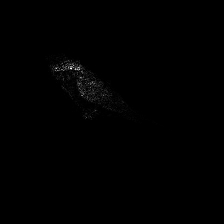

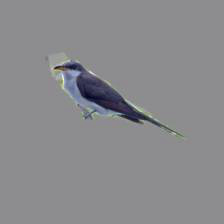

In [101]:
cum_attributions = attributions.sum(dim=1, keepdim=True)
cum_attributions = cum_attributions.repeat(1, 3, 1, 1)

# pos_attribution = cum_attributions.clamp(min=0)
pos_attribution = cum_attributions.abs()
pos_attribution = (pos_attribution - pos_attribution.min()) / (pos_attribution.max() - pos_attribution.min())
pos_attribution_np = (pos_attribution.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)
Image.fromarray(pos_attribution_np).show()

xs_scaled = (xs - xs.min()) / (xs.max() - xs.min())
xs_np = (xs_scaled.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)
Image.fromarray(xs_np).show()

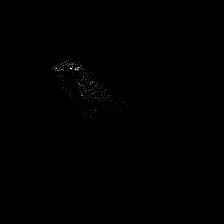

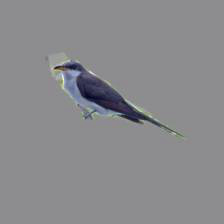

In [99]:
cum_attributions = attributions.sum(dim=1, keepdim=True)
cum_attributions = cum_attributions.repeat(1, 3, 1, 1)

pos_attribution = cum_attributions.clamp(min=0)
# pos_attribution = attributions
pos_attribution = (pos_attribution - pos_attribution.min()) / (pos_attribution.max() - pos_attribution.min())
pos_attribution_np = (pos_attribution.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
Image.fromarray(pos_attribution_np).show()

xs_scaled = (xs - xs.min()) / (xs.max() - xs.min())
xs_np = (xs_scaled.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
Image.fromarray(xs_np).show()

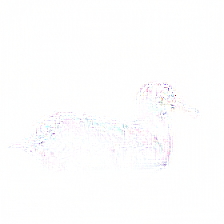

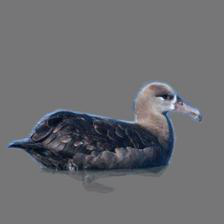

In [20]:
pos_attribution = attributions.clamp(max=0)
# pos_attribution = attributions
pos_attribution = (pos_attribution - pos_attribution.min()) / (pos_attribution.max() - pos_attribution.min())
pos_attribution_np = (pos_attribution.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
Image.fromarray(pos_attribution_np).show()

xs_scaled = (xs - xs.min()) / (xs.max() - xs.min())
xs_np = (xs_scaled.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
Image.fromarray(xs_np).show()

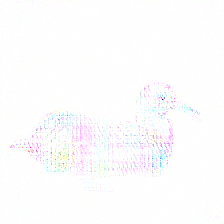

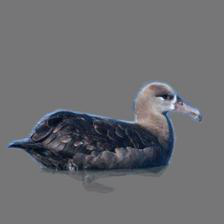

In [16]:
pos_attribution = attributions.clamp(max=0)
# pos_attribution = attributions
pos_attribution = (pos_attribution - pos_attribution.min()) / (pos_attribution.max() - pos_attribution.min())
pos_attribution_np = (pos_attribution.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
Image.fromarray(pos_attribution_np).show()

xs_scaled = (xs - xs.min()) / (xs.max() - xs.min())
xs_np = (xs_scaled.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
Image.fromarray(xs_np).show()

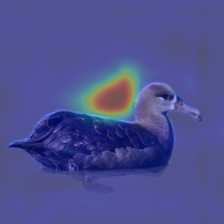

In [17]:
# with torch.no_grad():
#     _, softmaxes, pooled, _ = net(xs, inference=False)
#     pooled = pooled[node.name][child_name].squeeze(0)
#     softmaxes = softmaxes[node.name]#.squeeze(0)
#     softmaxes_split = torch.split(softmaxes, [node.num_protos_per_child[child_node.name] for child_node in node.children], dim=1)
#     idx = [temp_child_node.name for temp_child_node in node.children].index(child_name)
#     softmaxes_of_child_node = softmaxes_split[idx]

#     latent_activation = softmaxes_of_child_node[:, proto_idx, :, :]

Image.fromarray(get_heatmap(latent_activation, xs.squeeze())).show()

In [36]:
pos_attribution.min()

tensor(0., dtype=torch.float64)

In [39]:
pos_attribution_np.shape

(224, 224, 3)

In [57]:
child_name

'086+045'

In [59]:
img_iter = tqdm(enumerate(modifiedLabelLoader),
                    total=len(modifiedLabelLoader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

child_names = []
for i, (xs, orig_y, ys) in img_iter:
    child_name = coarse_label2name[ys.item()]
    child_names.append(child_name)
        
print(child_names)

['086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '086+045', '004+032'